In [56]:
# use these commands to install necesary packages and restart kernel before running the script

# upgrade to latest available sklearn package if needed
#%pip install -U scikit-learn 
# install glob if not already present
#%pip install glob2

First we install and import packages needed for the code.

## 1. Data Cleaning and Preparation

In [57]:
import warnings 
warnings.filterwarnings('ignore') # to keep the notebook cleaner - can disable to view warnings

import pandas as pd 
import os 
import glob 
import matplotlib.pyplot as plt

Then we collect all the HDB resale flat transaction data.

In [58]:
path = "./Kaggle_HDB/" # path to folder containing HDB data files 
file_list = glob.glob(os.path.join(path, "*.csv")) # get the file names

hdb_data = pd.DataFrame() # initialise
for file in file_list: # we read the data files one by one and combine into a single dataframe
    tmp = pd.read_csv(file)
    hdb_data = pd.concat([hdb_data,tmp],ignore_index=True)
    del tmp

In [59]:
hdb_data.dtypes # take a quick look at the column names and data types

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease         object
dtype: object

In [60]:
hdb_data.head() # take a quick look at the actual data

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease
0,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,9000.0,NaN
1,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,04 TO 06,31.0,IMPROVED,1977,6000.0,NaN
2,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,10 TO 12,31.0,IMPROVED,1977,8000.0,NaN
3,1990-01,ANG MO KIO,1 ROOM,309,ANG MO KIO AVE 1,07 TO 09,31.0,IMPROVED,1977,6000.0,NaN
4,1990-01,ANG MO KIO,3 ROOM,216,ANG MO KIO AVE 1,04 TO 06,73.0,NEW GENERATION,1976,47200.0,NaN


Some columns don't seem to be of the expected data type. 
`month` is actually stored as a string with year and month included. 
`remaining lease` should also be numerical but also stored as a string and is missing for some years.
We clean these two columns up before doing further exporation and analysis. 

In [61]:
# make a copy to clean up the data
hdb_data_clean = hdb_data.copy()

In [62]:
# we store the transaction date data as the year and assume prices do not fluctuate (much) by month
hdb_data_clean['year'] = hdb_data['month'].apply(lambda x: int(x[:4])) # extract the year from the original 'month' column

In [63]:
# to be consistent we re-calculate the remaining lease based on the transaction year and lease commence date (which actually just has the year)
hdb_data_clean['remaining_lease'] = hdb_data_clean['year'] - hdb_data['lease_commence_date']

In [64]:
hdb_data_clean.dtypes # take a quick look at the column names and data types again after cleaning

month                   object
town                    object
flat_type               object
block                   object
street_name             object
storey_range            object
floor_area_sqm         float64
flat_model              object
lease_commence_date      int64
resale_price           float64
remaining_lease          int64
year                     int64
dtype: object

In [65]:
hdb_data_clean.isnull().sum() # quick check for missing values

month                  0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
year                   0
dtype: int64

The cleaned dataset has all columns with the expected data type and no missing values, so we can proceed. 
We now explore the variables to determine which are suitable for use in our prediction and if any further issues still remain to be addressed.

First we look at the number of classes in each of the categorical variables in the dataset

In [66]:
categorical_variables = ['town','flat_type','street_name','storey_range','flat_model']
hdb_data_clean['flat_model'] = hdb_data_clean['flat_model'].str.upper() # some of these are the exact same just with lower/uppercase, so we standardise to all uppercase

for var in categorical_variables:
    n_classes = len(hdb_data_clean[var].unique())
    print('Number of classes for '+ var +': '+ str(n_classes))

Number of classes for town: 27
Number of classes for flat_type: 8
Number of classes for street_name: 568
Number of classes for storey_range: 25
Number of classes for flat_model: 20


`street_name` (and `block`) are probably too specific and thus not that helpful for our predictions, as there are already 568 classes for `street name` alone. 
`flat_model` is a more detailed breakdown of `flat_type`, so for this example, we use the broader category `flat_type`.

We take a look at the distribution across classes for the other categorical variables.

In [67]:
categorical_variables = ['town','flat_type','storey_range'] # keep only variables of interest in the list
for var in categorical_variables:
    print('Frequency counts for '+ var +':\n')
    print(hdb_data_clean[var].sort_values().value_counts(sort=False)) # look at frequency counts sorted by class names (instead of frequency)

Frequency counts for town:

ANG MO KIO         48237
BEDOK              61400
BISHAN             19522
BUKIT BATOK        40444
BUKIT MERAH        30518
BUKIT PANJANG      24241
BUKIT TIMAH         2283
CENTRAL AREA        6345
CHOA CHU KANG      33388
CLEMENTI           25755
GEYLANG            25679
HOUGANG            45476
JURONG EAST        22864
JURONG WEST        60708
KALLANG/WHAMPOA    24030
LIM CHU KANG          64
MARINE PARADE       7388
PASIR RIS          30267
PUNGGOL            12336
QUEENSTOWN         25922
SEMBAWANG          11016
SENGKANG           23903
SERANGOON          21125
TAMPINES           73101
TOA PAYOH          28525
WOODLANDS          58735
YISHUN             63309
Name: town, dtype: int64
Frequency counts for flat_type:

1 ROOM                1273
2 ROOM                9863
3 ROOM              272580
4 ROOM              309314
5 ROOM              170408
EXECUTIVE            62641
MULTI GENERATION       279
MULTI-GENERATION       223
Name: flat_type, dtype:

In [68]:
# extremely low counts for flats in LIM CHU KANG in the transaction data, so we take a look
hdb_data_clean[hdb_data_clean['town']=='LIM CHU KANG']

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,resale_price,remaining_lease,year
3217,1990-03,LIM CHU KANG,3 ROOM,3,LIM CHU KANG RD,01 TO 03,59.0,IMPROVED,1980,20400.0,10,1990
5988,1990-06,LIM CHU KANG,4 ROOM,3,LIM CHU KANG RD,04 TO 06,83.0,IMPROVED,1980,32500.0,10,1990
10136,1990-10,LIM CHU KANG,4 ROOM,4,LIM CHU KANG RD,01 TO 03,83.0,IMPROVED,1980,45700.0,10,1990
14335,1991-02,LIM CHU KANG,3 ROOM,3,LIM CHU KANG RD,04 TO 06,70.0,IMPROVED,1980,33200.0,11,1991
15153,1991-03,LIM CHU KANG,4 ROOM,4,LIM CHU KANG RD,01 TO 03,83.0,IMPROVED,1980,45500.0,11,1991
...,...,...,...,...,...,...,...,...,...,...,...,...
211688,1998-09,LIM CHU KANG,3 ROOM,4,LIM CHU KANG RD,01 TO 03,59.0,IMPROVED,1980,66000.0,18,1998
216988,1998-10,LIM CHU KANG,3 ROOM,3,LIM CHU KANG RD,01 TO 03,70.0,IMPROVED,1980,88000.0,18,1998
222341,1998-11,LIM CHU KANG,3 ROOM,3,LIM CHU KANG RD,04 TO 06,59.0,IMPROVED,1980,65000.0,18,1998
222342,1998-11,LIM CHU KANG,4 ROOM,4,LIM CHU KANG RD,01 TO 03,83.0,IMPROVED,1980,100000.0,18,1998


In [69]:
print('Max lease ending year for flats in Lim Chu Kang based on resale data is: ' +
      str(max(hdb_data_clean[hdb_data_clean['town']=='LIM CHU KANG'].apply(lambda x: x['remaining_lease']+x['year'],axis=1)))) # sum up remaining lease and transaction year to find lease end year, then get the maximum

Max lease ending year for flats in Lim Chu Kang based on resale data is: 2016


We assume there are no more flats in this area that will be available for resale (as the lease would have been up in 2016). Thus, the transaction data from this town is likely to not be useful / relevant to our prediction analyses (which is assumed to be for current and future resale prices) and we remove it from our clean dataset.

In [70]:
hdb_data_clean = hdb_data_clean[hdb_data_clean['town']!='LIM CHU KANG'].copy() # keep only those that are not in LIM CHU KANG

For the other categorical variables, we perform some grouping on them due to duplicates / overlaps in class labels.

In [71]:
# two class names but referring to the same class in flat type, so we replace one to group them together
hdb_data_clean['flat_type'] = hdb_data_clean['flat_type'].replace('MULTI GENERATION','MULTI-GENERATION')

# make some arbitrary decisions to group the classes in storey_range due to overlaps and lack of more specific data
# we try to get roughly equal data points in each of the low, mid and high floor groups 
# and we assume that the price does not differ (much) based on the exact floor within each of these groups
hdb_data_clean['storey_range_grp'] = hdb_data_clean['storey_range'].copy()

storey_grouping = {'01 TO 03':'LOW', '01 TO 05':'LOW', '04 TO 06':'LOW', # low floor usually refers to first 5 floors
                   '06 TO 10':'MID', '07 TO 09':'MID'} # mid floor usually refers to up to 10th floor
for key,value in storey_grouping.items():
    hdb_data_clean['storey_range_grp'] = hdb_data_clean['storey_range_grp'].replace(key,value)

hdb_data_clean.loc[~hdb_data_clean['storey_range_grp'].isin(storey_grouping.values()),'storey_range_grp'] = 'HIGH' # above 10th storey is usually considered high floor

hdb_data_clean['storey_range_grp'].value_counts() # see if there is a roughly equal distribution across the groups

LOW     381326
HIGH    253608
MID     191583
Name: storey_range_grp, dtype: int64

Now we take a look at the numerical variables to check for cross-correlation.

In [72]:
numerical_variables = ['year','floor_area_sqm','lease_commence_date','remaining_lease'] # leaving resale_price out since this is the variable to be predicted
hdb_data_clean[numerical_variables].corr()

,year,floor_area_sqm,lease_commence_date,remaining_lease
year,1.000000,0.071783,0.373262,0.448331
floor_area_sqm,0.071783,1.000000,0.465866,-0.390865
lease_commence_date,0.373262,0.465866,1.000000,-0.661919
remaining_lease,0.448331,-0.390865,-0.661919,1.000000


`remaining lease` and `lease_commencement_date` have the highest correlation. Furthermore, we can actually obtain `lease_commencement_date` from `remaining lease` and (transaction) `year`. Of these 3 variables, (transaction) `year` and `remaining_lease` are assumed to be more relevant for the prediction, so we choose to drop `lease_commencement_date` and keep the other two variables.

We keep just the variables we want to use in the cleaned dataset.

In [73]:
hdb_data_clean = hdb_data_clean[['resale_price', # the variable to be predicted
                                 'town','flat_type','storey_range_grp', # categorical predictors
                                 'year','floor_area_sqm','remaining_lease']].copy() # numerical predictors

## 2. Data visualisation

We take a quick look at the distribution of the target variable (resale price), and notice that there is a positive skew (right-skewed) distribution for this variable.

<AxesSubplot:>

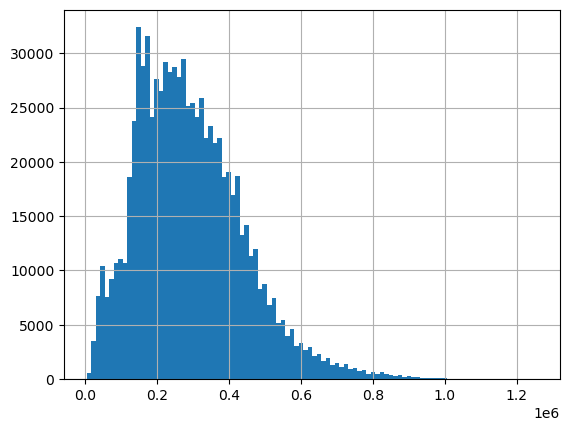

In [74]:
hdb_data_clean['resale_price'].hist(bins=100)

With these selected variables, (based on contextual knowledge) we expect that resale prices will be higher for:
- Larger flats 
- Newer flats 
- Flats on higher floors 
- More central / mature towns
- More recent transactions

(with all other factors held constant)

We take a look at how some of the selected variables relate to the resale flat prices through graphs.

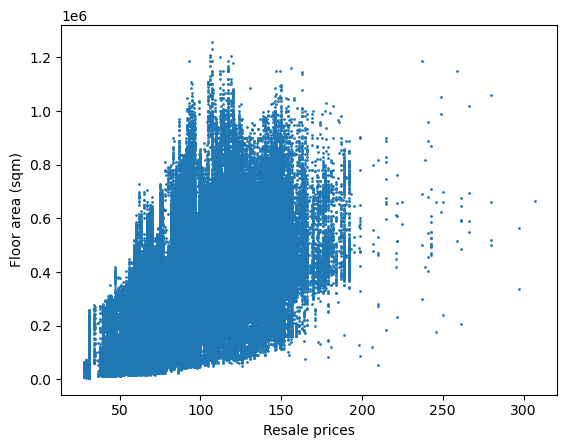

In [75]:
plt.scatter(hdb_data_clean['floor_area_sqm'],hdb_data_clean['resale_price'],s=1)
plt.xlabel('Resale prices')
plt.ylabel('Floor area (sqm)')
plt.show()

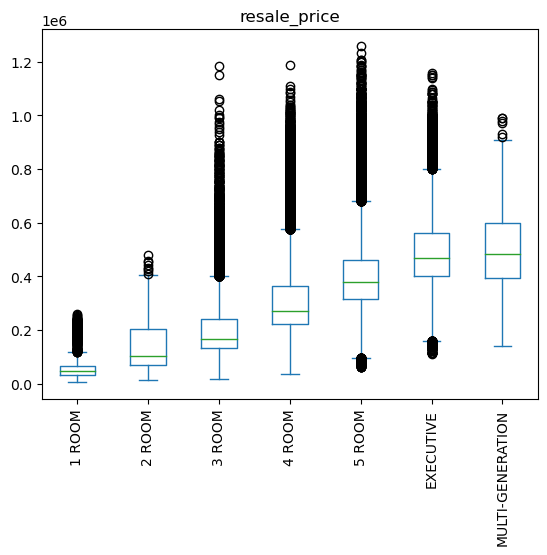

In [76]:
hdb_data_clean.plot.box(column='resale_price', by='flat_type')
plt.xticks(rotation=90)
plt.show()

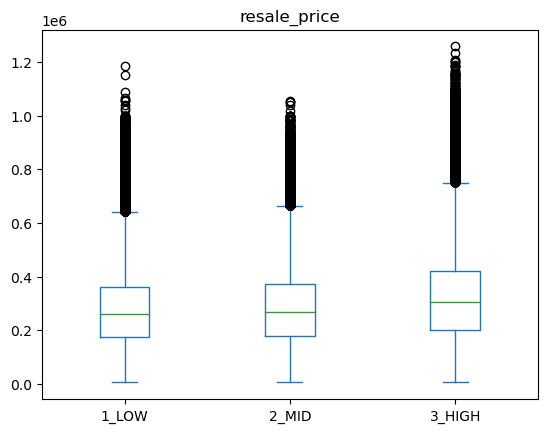

In [78]:
# create a temporary variable to get custom order for the boxplot (which will be by numerical / alphabetical when plotted)
hdb_data_clean['storey_range_ordered'] = hdb_data_clean['storey_range_grp'].copy()
hdb_data_clean['storey_range_ordered'] = hdb_data_clean['storey_range_ordered'].replace('LOW','1_LOW')
hdb_data_clean['storey_range_ordered'] = hdb_data_clean['storey_range_ordered'].replace('MID','2_MID')
hdb_data_clean['storey_range_ordered'] = hdb_data_clean['storey_range_ordered'].replace('HIGH','3_HIGH')

hdb_data_clean.plot.box(column='resale_price', by='storey_range_ordered')
plt.show()

hdb_data_clean.drop(columns='storey_range_ordered',inplace=True) # remove the temporary variable

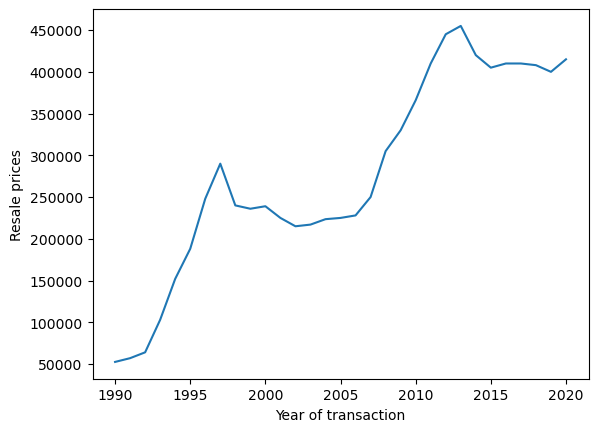

In [11]:
plt.plot(range(hdb_data_clean['year'].min(),hdb_data_clean['year'].max()+1),
         hdb_data_clean[['resale_price','year']].groupby('year').median())
plt.ylabel('Resale prices')
plt.xlabel('Year of transaction')
plt.show()

The trends are generally what we expect even without controlling for the other variables yet.
However, it is still not so clear what is the most important factor in determining resale flat transaction prices, which is what we will explore through modelling.

## 3. Test set and model selection

Since we want to predict resale prices (a numerical variable), and we have the ground truth data (actual resale transaction prices), we will be considering supervised regression models. 
Given that we have limited computational power and the predictor variables have a generally linear relationship with the target variable, and we want to be able to interpret the results (e.g., importance of the predictors) we will proceed with linear regression models.

To use linear regresion models, we need to encode the categorical variables before modelling.

In [79]:
from sklearn.preprocessing import LabelEncoder
hdb_data_clean['flat_encoded'] = LabelEncoder().fit_transform(hdb_data_clean['flat_type'])

# label encoder will map based on alphabetical order which is not what we want for the storey range, so we specify the levels to use here
hdb_data_clean['storey_encoded'] = hdb_data_clean['storey_range_grp'].map({'LOW':0,'MID':1,'HIGH':2}) 

# for town, since it is not ordinal, we use one hot encoding
from sklearn.preprocessing import OneHotEncoder
town_encoded = OneHotEncoder(sparse_output=False).set_output(transform="pandas").fit_transform(hdb_data_clean[['town']])
hdb_data_clean = pd.concat([hdb_data_clean,town_encoded],axis=1)

We also need to split the data into test and train sets. We use a stratified split on`flat_type` which has the most uneven split among the categorical variables.

In [80]:
#pip install scikit-learn
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(hdb_data_clean[['flat_encoded','storey_encoded','year','floor_area_sqm','remaining_lease'] + list(town_encoded.columns)], # predictors
                                                 hdb_data_clean['resale_price'],
                                                 test_size = 0.3, # 30% kept for testing set, 70% used for training
                                                 stratify = hdb_data_clean['flat_type'], # stratify on flat_type
                                                 random_state = 42) # set random seed for reproducibility

Then we define the function we will use to score all the models. We will look at the R-squared, mean absolute error and mean squared error of the model's prediction vs the actual values.

In [81]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import math

def score_model(model_name,y_pred):
    print(model_name+' performance: r2 = '+ str(r2_score(y_test,y_pred))+
          ', MAE = '+ str(mean_absolute_error(y_test,y_pred))+
          ', RMSE = '+ str(math.sqrt(mean_squared_error(y_test,y_pred))))

Now we fit and score a baseline model to check the performance.

In [ ]:
# fit linear regression model on training data and predict resale price using test data, then score the result
from sklearn.linear_model import LinearRegression

ols_reg = LinearRegression().fit(X_train,y_train)
y_pred_ols = ols_reg.predict(X_test)
score_model('Linear regression',y_pred_ols)

Linear regression performance: r2 = 0.7949733717866585, MAE = 51507.86005203851, RMSE = 67336.53322959587


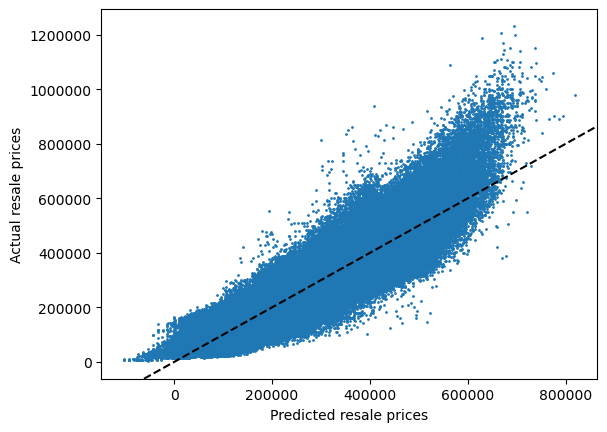

In [58]:
# we also plot the prediction vs the actual values to visualise the performance
fig,ax = plt.subplots()
ax.scatter(y_pred_ols,y_test,s=1)
ax.axline((0,0),slope=1,color='k',linestyle='--') # add y=x line for reference
plt.gca().ticklabel_format(axis='y', style='plain') # force y axis not to display as exponential
plt.xlabel('Predicted resale prices')
plt.ylabel('Actual resale prices')
plt.show()

## 4. Model tuning

We will try using ridge and lasso regression to apply penalty terms to the linear regression model and tune these to see how much we can improve the performance.

In [59]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

# due to limited computational resources we just do the tuning on a small range of values for alpha instead of an extensive model tuning
parameters = {'alpha': [0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10],
              'random_state': [42], # set random seed for reproducibility
              }

ridge_tuning_model = GridSearchCV(Ridge(),
                                  param_grid = parameters,
                                  scoring = 'neg_mean_squared_error', # the baseline model's RMSE is quite high so we use it to tune for better performance
                                  cv = 5) # the standard is to do a 5 fold cross validation
ridge_tuning_model.fit(X_train,y_train)
ridge_tuning_model.best_params_

{'alpha': 1, 'random_state': 42}

In [60]:
ridge_reg = Ridge(alpha = 1,
                  random_state = 42).fit(X_train,y_train) # use the best parameters from the tuning to fit the model
y_pred_ridge = ridge_reg.predict(X_test)
score_model('Ridge regression (tuned)',y_pred_ridge)

Ridge regression (tuned) performance: r2 = 0.7949733719145795, MAE = 51507.54798657384, RMSE = 67336.53320858943


In [61]:
from sklearn.linear_model import Lasso

# due to limited computational resources we just do the tuning on a small range of values for alpha instead of an extensive model tuning
parameters = {'alpha': [0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10],
              'selection': ['cyclic','random'],# increase this to prevent cases where model cannot converge
              'random_state': [42], # set random seed for reproducibility
              }

lasso_tuning_model = GridSearchCV(Lasso(),
                                  param_grid = parameters,
                                  scoring = 'neg_mean_squared_error', # the baseline model's RMSE is quite high so we use it to tune for better performance
                                  cv = 5) # the standard is to do a 5 fold cross validation
lasso_tuning_model.fit(X_train,y_train)
lasso_tuning_model.best_params_

{'alpha': 0.01, 'random_state': 42, 'selection': 'cyclic'}

In [62]:
lasso_reg = Lasso(alpha = 0.01, 
                  selection = 'cyclic',
                  random_state = 42).fit(X_train,y_train) # use the best parameters from the tuning to fit the model
y_pred_lasso = lasso_reg.predict(X_test)
score_model('Lasso regression (tuned)',y_pred_lasso)

Lasso regression (tuned) performance: r2 = 0.7949733729458133, MAE = 51507.830655881866, RMSE = 67336.53303924628


Unfortunately there is only negligible improvements with ridge and lasso regression models. We try again with linear, ridge and lasso regression using with polynomial regression (up to degree 2) - we allow the numerical predictors to appear as squared versions to account for non-linear relationships with the target variable.

In [64]:
# create the squared predictors for train and test set
X_train2 = X_train.copy()
X_train2['year^2'] = X_train['year']**2
X_train2['floor_area_sqm^2'] = X_train['floor_area_sqm']**2
X_train2['remaining_lease^2'] = X_train['remaining_lease']**2

X_test2 = X_test.copy()
X_test2['year^2'] = X_test['year']**2
X_test2['floor_area_sqm^2'] = X_test['floor_area_sqm']**2
X_test2['remaining_lease^2'] = X_test['remaining_lease']**2

In [65]:
# fit polynomial regression and check performance
ols_reg2 = LinearRegression().fit(X_train2,y_train)
y_pred_ols2 = ols_reg2.predict(X_test2)
score_model('Polynomial regression (degree 2)',y_pred_ols2)

Polynomial regression (degree 2) performance: r2 = 0.7956333069965003, MAE = 51412.265475415275, RMSE = 67228.07520623274


In [66]:
# tune ridge regression model with the training data including squared predictors
parameters = {'alpha': [0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10],
              'random_state': [42], # set random seed for reproducibility
              }

ridge_tuning_model2 = GridSearchCV(Ridge(),
                                  param_grid = parameters,
                                  scoring = 'neg_mean_squared_error', # the baseline model's RMSE is quite high so we use it to tune for better performance
                                  cv = 5) # the standard is to do a 5 fold cross validation
ridge_tuning_model2.fit(X_train2,y_train)
ridge_tuning_model2.best_params_

{'alpha': 0.1, 'random_state': 42}

In [67]:
# fit polynomial ridge regression model  and check performance
ridge_reg2 = Ridge(alpha = 0.1,
                  random_state = 42).fit(X_train2,y_train) # use the best parameters from the tuning to fit the model
y_pred_ridge2 = ridge_reg2.predict(X_test2)
score_model('Polynomial ridge regression (tuned)',y_pred_ridge2)

Polynomial ridge regression (tuned) performance: r2 = 0.7956333224552274, MAE = 51412.2348014216, RMSE = 67228.07266359607


In [68]:
# tune ridge regression model with the training data including squared predictors
parameters = {'alpha': [0.0001,0.001,0.01,0.1,1,2,3,4,5,6,7,8,9,10],
              'selection': ['cyclic','random'],
              'random_state': [42], # set random seed for reproducibility
              }

lasso_tuning_model2 = GridSearchCV(Lasso(),
                                  param_grid = parameters,
                                  scoring = 'neg_mean_squared_error', # the baseline model's RMSE is quite high so we use it to tune for better performance
                                  cv = 5) # the standard is to do a 5 fold cross validation
lasso_tuning_model2.fit(X_train2,y_train)
lasso_tuning_model2.best_params_

{'alpha': 0.1, 'random_state': 42, 'selection': 'random'}

In [69]:
# tune ridge regression model with the training data including squared predictors
lasso_reg2 = Lasso(alpha = 0.1, 
                  selection = 'random',
                  random_state = 42).fit(X_train2,y_train) # use the best parameters from the tuning to fit the model
y_pred_lasso2 = lasso_reg2.predict(X_test2)
score_model('Polynomial lasso regression (tuned)',y_pred_lasso2)

Polynomial lasso regression (tuned) performance: r2 = 0.795449812243417, MAE = 51436.1699003619, RMSE = 67258.24947555731


Overall, the additional penalty terms introduced via ridge and lasso regression, as well as the polynomial features used in polynomial regression, do not add much to the variance explained or reduce prediction error by much. 

Hence, we use the baseline linear model whichis the easiest to interpret for our prediction analysis.

## 5. Model evaluation and interpretation

In [28]:
# get the score of the linear regression model again
score_model('Linear regression',y_pred_ols)

Linear regression performance: r2 = 0.7949733717866585, MAE = 51507.86005203851, RMSE = 67336.53322959587


For the linear regression model: 

With an r2 (coefficient of determination) of 0.79, the baseline model already explains 79% of the resale price variance. 

The MAE (mean absolute error) of ~$52,000 indicates that the model's predicted resale price differs from the actual resale price by $52,000 on average. This is ~19% of the median resale price in the dataset.

Similarly, the RMSE (root mean squared error) of ~$67,000 indicates that the error in predicted resale price is $67,000 on average when computed using the root of the squared errors.

In [ ]:
# place the coefficients from the linear regression into a dataframe
predictor_weights = pd.DataFrame(ols_reg.coef_,X_train.columns,columns=['Coefficients']).sort_values('Coefficients',ascending=False).reset_index().rename(columns={'index':'Predictors'})

# tidy up and save the list of towns in the datafrme of coefficients
town_list = list(predictor_weights['Predictors'][predictor_weights['Predictors'].str.startswith('town')].values)
town_list = [town.replace('town_','') for town in town_list]
predictor_weights['Predictors'] = predictor_weights['Predictors'].str.replace('town_','')

In [27]:
predictor_weights

,Predictors,Coefficients
0,MARINE PARADE,99527.448075
1,BUKIT TIMAH,89014.734592
2,CENTRAL AREA,88075.457925
3,BUKIT MERAH,73670.458575
4,QUEENSTOWN,73024.766149
5,BISHAN,64881.542524
6,TOA PAYOH,47923.724999
7,KALLANG/WHAMPOA,44579.616379
8,flat_encoded,35121.976355
9,CLEMENTI,33272.864948


Looking at the predictor weights, we see that `town` is the most important factor for resale prices, with the model showing that resale units located in Marine Parade cost ~$100,000 more than those in other regions while flats in Sembawang are selling for ~$108,000 less on average, with all other factors held constant.

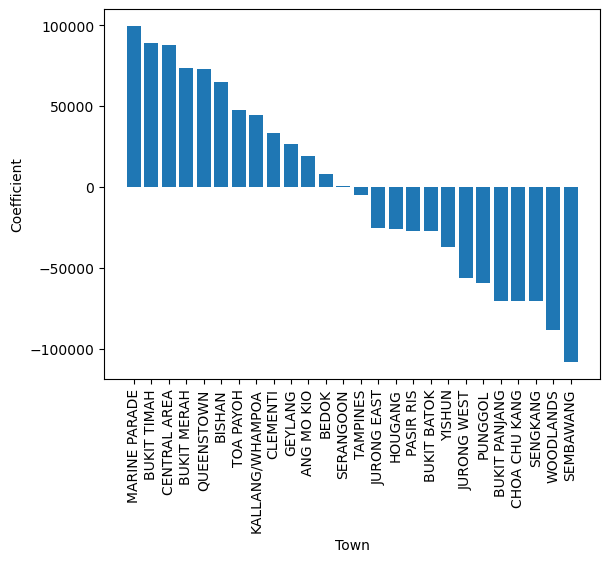

In [ ]:
plt.bar(town_list,predictor_weights[predictor_weights['Predictors'].isin(town_list)]['Coefficients'])
plt.xticks(rotation=90)
plt.xlabel('Town')
plt.ylabel('Coefficient')
plt.show()

We also see that the resale price increases by about $35,000 on average as we go up the list of flat types (1 room --> 2 room --> 3 room --> 4 room --> 5 room --> executive --> multi-generation)

Year on year, the resale transaction prices are also increasing by about $13,000 on average.

Similarly, resale flats become more expensive as they go from low floor to mid floor to high floor, by about $10,000 on average.

Homebuyers are also paying ~$2,000 per additional sqm of a resale flat.

Finally, older resale flats are generally cheaper by about $3,000 per year (i.e., with each less year remaining on the lease).

In [55]:
# to isolate only the predictors that are not towns
predictor_weights[~predictor_weights['Predictors'].isin(town_list)]

,Predictors,Coefficients
8,flat_encoded,35121.976355
12,year,12997.925428
13,storey_encoded,9667.074945
15,floor_area_sqm,2192.721021
17,remaining_lease,-3016.643947


## 6. Additional modelling

We also try modelling with some other regression methods to take a look at the performance.

In [ ]:
# fit KNN regression model on training data and predict resale price using test data, then score the result
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor().fit(X_train,y_train)
y_pred_knn = knn_reg.predict(X_test)
score_model('KNN regression',y_pred_knn)

KNN regression performance: r2 = 0.9527393258147803, MAE = 20713.824401595437, RMSE = 32329.245925095755


The performance for KNN regression is much better than for linear regression - however, we are not able to interpret feature importance and analyse the factors contributing to the resale price with this model. If our aim is just to have accurate price predictions, this may be a better choice.

In [87]:
# fit decision tree regression model on training data and predict resale price using test data, then score the result
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(random_state=42).fit(X_train,y_train) # set random seed for reproducibility
y_pred_tree = tree_reg.predict(X_test)
score_model('Decision tree regression',y_pred_tree)
print('Decision tree depth is '+str(tree_reg.get_depth()))

Decision tree regression performance: r2 = 0.9615835287239433, MAE = 19418.558152429927, RMSE = 29147.704217724095
Decision tree depth is 51


Similarly, the performance for decision tree regression is much better than for linear regression. While we are able to interpret the factors contributing to the resale price with this model using the splits in the decision tree, we notice that the tree depth is 51 to achieve such performance. This may also be rather complex to interpret with many steps needed to reach the leaf nodes (final resale price). Again, if our aim is just to have accurate price predictions, this may be a better choice, and it also runs very quickly.

In [ ]:
# fit SVM regression model on training data and predict resale price using test data, then score the result
from sklearn import svm
svm_reg = svm.SVR().fit(X_train,y_train)
y_pred_svm = svm_reg.predict(X_test)
score_model('SVM regression',y_pred_svm)

SVM regression was also attempted but it took too long to run - this seems to be the most computationally heavy algorithm tried here. Without access to GPU, this is likely not a suitable choice for our model.